In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import copy
from collections import OrderedDict
import argparse
import json
import pickle
from datetime import datetime

from sklearn.metrics import classification_report, roc_curve, precision_recall_curve,roc_auc_score, f1_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor


import xgboost as xgb

import shap

from imblearn.over_sampling import SMOTE

import utils

%matplotlib inline


ModuleNotFoundError: No module named 'numpy.core._multiarray_umath'

Using TensorFlow backend.


Recall from previous notebook the top feature importances:

![SHAP values](plots/xgb_shap_importance.png)


We now wish to take what we learned to create a smaller version of the model that can take in user input and convert it to useful features.

# 1.0 Load Data

In [2]:
#get directory
df_train_path = os.path.join('data','df_train_scaled.csv')
df_test_path = os.path.join('data','df_test_scaled.csv')

In [3]:
df_train = pd.read_csv(df_train_path, compression='zip',index_col=0)
df_train.head()

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


,pub_rec,grade,purp_renewable_energy,revol_bal,open_acc,mort_acc,purp_credit_card,purp_car,e_exec,verification_status,...,installment,total_acc,e_admin,purp_medical,purp_vacation,e_self,purp_debt_consolidation,int_rate,annual_inc,purp_home_improvement
2139270,0.0,-1.817008,0,-0.508426,-0.843970,-0.718077,0,0,0,0,...,-0.788166,-1.415080,0,0,0,0,1,0.190831,-1.073069,0
2139245,0.0,-2.586479,0,-0.549872,0.075527,-0.718077,0,0,0,0,...,-1.440208,-0.980748,0,0,0,0,1,0.653814,-0.507501,0
2139236,0.0,1.260876,0,-0.559592,-0.292272,-0.718077,0,0,0,0,...,-1.099830,-0.720149,0,0,0,0,1,-1.133175,0.855853,0
2139235,0.0,-0.278066,0,-0.594821,0.995025,-0.718077,0,0,0,0,...,-1.365033,-0.546417,0,0,0,0,0,-0.536115,-1.110524,0
2139225,0.0,1.260876,0,0.226401,0.627226,-0.718077,0,0,0,0,...,-0.870123,3.101968,0,0,0,0,0,-0.999098,1.324038,1


In [4]:
df_train.shape

(1292073, 43)

In [5]:
df_test = pd.read_csv(df_test_path, compression='zip', index_col=0)
df_test.head()

,pub_rec,grade,purp_renewable_energy,revol_bal,open_acc,mort_acc,purp_credit_card,purp_car,e_exec,verification_status,...,installment,total_acc,e_admin,purp_medical,purp_vacation,e_self,purp_debt_consolidation,int_rate,annual_inc,purp_home_improvement
244697,0.0,1.316121,0,-0.258040,-0.172649,-0.335020,0,0,0,2,...,2.819585,-0.001213,0,0,0,0,0,-1.237809,0.263661,0
244789,0.0,-0.236910,0,0.935375,2.552677,-0.335020,1,0,0,2,...,0.289097,1.790371,0,0,0,0,0,0.416115,0.411947,0
244459,0.0,-1.013426,0,-0.262623,-0.354337,0.730536,0,0,0,2,...,2.253124,0.243094,0,0,0,0,1,1.040837,-0.181633,0
245213,0.0,0.539606,0,-0.659508,-1.081091,0.197758,1,0,1,1,...,0.233329,-1.059876,0,0,0,0,0,-0.630029,-0.059664,0
245189,0.0,1.316121,0,-0.490607,-0.354337,-0.335020,0,0,0,0,...,-1.027633,-0.815569,0,0,0,0,0,-1.104394,0.902531,1


In [6]:
df_test.shape

(11534, 43)

# 2.0 FICO to Grade: An Example

In [7]:
df_fico_grade = pd.read_csv('data/grade_to_fico.csv')
df_fico_grade.head()

,sub_grade,score,value
0,A1,789,34
1,A2,780,33
2,A3,769,32
3,A4,761,31
4,A5,741,30


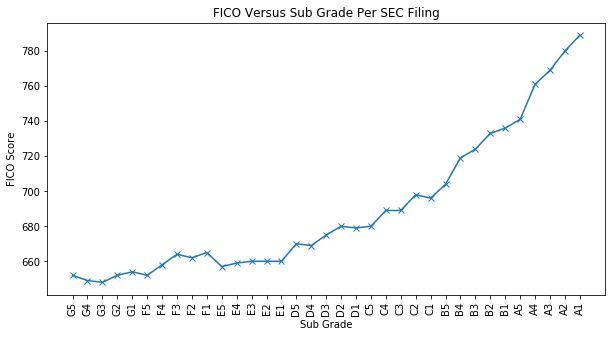

In [8]:
plt.figure(figsize=(10,5))
plt.plot(df_fico_grade['value'], df_fico_grade['score'], marker='x')
plt.xticks(range(df_fico_grade.shape[0]) , df_fico_grade['sub_grade'][::-1], rotation='vertical')
plt.xlabel('Sub Grade')
plt.ylabel("FICO Score")
plt.title("FICO Versus Sub Grade Per SEC Filing")
plt.savefig(os.path.join('plots','fico_grade_line.png'))
plt.show()

In [9]:
#instantiate regressor
knn = KNeighborsRegressor(n_neighbors=1)
#fit to data
knn.fit(np.reshape(df_fico_grade['score'].values, (-1, 1)), 
        df_fico_grade['value'])
#make sample prediction
knn.predict(np.reshape([750], (1,-1)))[0]

30.0

### Save KNN Regression

In [10]:
#save the model
with open(os.path.join('models', 'knn_regression.pkl'), 'wb') as handle:
    pickle.dump(knn,
                handle)

# 3.0 FICO to Interest Rate

In [11]:
df_fico_apr = pd.read_csv('data/grade_to_apr.csv')
df_fico_apr.head()

,grade_num,loan_grade,apr,36_mo,60_mo
0,34,A1,6.03,6.78,7.30
1,33,A2,6.97,7.99,8.26
2,32,A3,7.62,8.99,8.91
3,31,A4,8.60,9.98,9.91
4,30,A5,9.25,10.99,10.56


In [12]:
df_fico_apr[df_fico_apr['grade_num']==30]['36_mo']

4    10.99
Name: 36_mo, dtype: float64

# 4.0 Fit Model

## 4.1 Prepare Data

In [13]:
#target variable
target_col = 'loan_status'

#training variables
X_train = df_train.drop(columns=[target_col])
y_train = df_train[target_col]

#instantiate smote
sm = SMOTE(random_state=42)
#apply oversampling to training data
X_train, y_train = sm.fit_resample(X_train, y_train)

#test variables
X_test = df_test.drop(columns=[target_col])
y_test = df_test[target_col]

## 4.2 Training

In [14]:
#instantiate model
clf = xgb.XGBClassifier(colsample_bytree=0.9, eta=0.3, max_depth=3)
#fit to data
clf.fit(X_train, y_train)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, eta=0.3, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

## 4.3 Predictions

In [15]:
#make predictions
y_pred = clf.predict(X_test.values)
confusion_matrix(y_test, y_pred)

array([[ 187,  437],
       [1700, 9210]])

In [16]:
fpr, tpr, thresholds = roc_curve(y_test,
                                 clf.predict_proba(X_test.values)[:,1],
                                 pos_label=1)

In [17]:
precision, recall, thresholds = precision_recall_curve(y_test,
                                                       clf.predict_proba(X_test.values)[:,1],
                                                       pos_label=1)

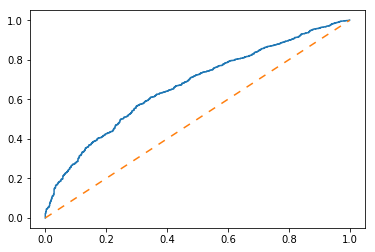

In [18]:
plt.plot(fpr, tpr, label='XGB')
plt.plot([0,1], [0,1], label='No Discrimination', linestyle='-', dashes=(5, 5))
plt.show()

In [19]:
xgb_auc = roc_auc_score(y_test, clf.predict_proba(X_test.values)[:,1])
print("xgb_auc: {}".format(xgb_auc))

xgb_auc: 0.6675232526028814


In [20]:
f1_xgb = f1_score(y_test, y_pred)

print("f1_xgb (binary): {}\n".format(f1_xgb))
print(classification_report(y_test, y_pred))

f1_xgb (binary): 0.896045142773751

              precision    recall  f1-score   support

           0       0.10      0.30      0.15       624
           1       0.95      0.84      0.90     10910

    accuracy                           0.81     11534
   macro avg       0.53      0.57      0.52     11534
weighted avg       0.91      0.81      0.86     11534



## 4.4 Save Model

In [21]:
#define location to save trained model
save_model_dir = os.path.join('models','xgb_cv_compact.pkl')
print("Saving model at: {}".format(save_model_dir))

#save the model
with open(save_model_dir, 'wb') as handle:
    pickle.dump(clf,
                handle)

Saving model at: models/xgb_cv_compact.pkl


# 5.0 Case by Case Timing

In [22]:
predictions_list = []

for x, y in zip(X_test.values, y_test):
    start  = datetime.now()
    pred = clf.predict(x.reshape(1, -1))[0]
    delta = (datetime.now() - start).microseconds
    pred_dict = {'y_true': y, 'y_pred': pred, 'pred_time': delta}
    predictions_list.append(pred_dict)
    
pred_df = pd.DataFrame(predictions_list)

pred_df.head()

,pred_time,y_pred,y_true
0,3754,1,1
1,327,0,1
2,198,0,1
3,192,1,1
4,187,1,1


In [23]:
pred_df.describe()

,pred_time,y_pred,y_true
count,11534.000000,11534.000000,11534.000000
mean,155.172707,0.836397,0.945899
std,46.939933,0.369931,0.226227
min,142.000000,0.000000,0.000000
25%,146.000000,1.000000,1.000000
50%,147.000000,1.000000,1.000000
75%,150.000000,1.000000,1.000000
max,3754.000000,1.000000,1.000000


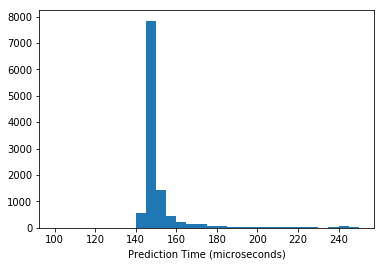

In [24]:
plt.hist(pred_df['pred_time'], bins=np.arange(100, 255, 5))
plt.xlabel("Prediction Time (microseconds)")
plt.show()

## 6.0 Custom Input 

In [25]:
df_train.columns

Index(['pub_rec', 'grade', 'purp_renewable_energy', 'revol_bal', 'open_acc',
       'mort_acc', 'purp_credit_card', 'purp_car', 'e_exec',
       'verification_status', 'purp_other', 'e_other', 'home_ownership',
       'e_educ', 'loan_status', 'emp_length', 'e_driver', 'revol_util',
       'purp_moving', 'loan_amnt', 'time_delta', 'e_law', 'e_health', 'e_fin',
       'purp_small_business', 'sub_grade', 'application_type', 'dti',
       'e_manager', 'purp_major_purchase', 'pub_rec_bankruptcies',
       'purp_house', 'term', 'installment', 'total_acc', 'e_admin',
       'purp_medical', 'purp_vacation', 'e_self', 'purp_debt_consolidation',
       'int_rate', 'annual_inc', 'purp_home_improvement'],
      dtype='object')

Ask user for:
- FICO score
- loan_amount
- term
- dti
- home_ownership
- mort_acc: number of mortage accounts 
- annual_inc
- open_acc: number of open credit lines
- employment
- verification_status: loan verified or not 
- revol_bal
- revol_util: Revolving linΩ utilization rate, or the amount of credit the borrower is using relative to all available revolving credit
- pub_rec
- emp_length
- purpose


calculate:
- sub_grade
- grade
- installment
- int_rate


In [26]:
def emp_title_to_dict(e_title):
    #force make string if not and make lower
    title_lower = str(e_title).lower()
    
    #list of employment types to consider
    emp_list = ['e_manager', 'e_educ', 'e_self',
                'e_health', 'e_exec', 'e_driver',
                'e_law', 'e_admin', 'e_fin', 'e_other']
    
    #instantiate title dict
    title_dict = dict(zip(emp_list, len(emp_list)*[0]))
    
    #check and fill out dict
    if any(job in title_lower for job in ['manag', 'superv']):
        title_dict['e_manager'] = 1
        
    elif 'teacher' in title_lower:
        title_dict['e_educ'] = 1

    elif 'owner' in title_lower:
        title_dict['e_self'] = 1
    
    elif any(job in title_lower for job in ['rn', 'registered nurse', 'nurse',
                                          'doctor', 'pharm', 'medic']):
        title_dict['e_health'] = 1
    
    elif any(job in title_lower for job in ['vice president', 'president', 'director',
                                          'exec', 'chief']):
        title_dict['e_exec'] = 1
        
    elif any(job in title_lower for job in ['driver', 'trucker']):
        title_dict['e_driver'] = 1   
    
    elif any(job in title_lower for job in ['lawyer', 'legal', 'judg']):
        title_dict['e_law'] = 1    
    
    elif 'admin' in title_lower:
        title_dict['e_admin'] = 1    
    
    elif any(job in title_lower for job in ['analyst', 'financ', 'sales']):
        title_dict['e_fin'] = 1
    else:
        title_dict['e_other'] = 1
    
    return title_dict



def purp_to_int(title):

    
    #force make string if not and make lower
    title_lower = str(title).lower()
    
    #list of employment types to consider
    title_list = ['purp_car', 'purp_credit_card', 'purp_debt_consolidation',
                  'purp_educational', 'purp_home_improvement',
                  'purp_house', 'purp_major_purchase', 'purp_medical',
                  'purp_moving', 'purp_other', 'purp_renewable_energy',
                  'purp_small_business', 'purp_vacation', 'purp_wedding']
    
    #instantiate title dict
    title_dict = dict(zip(title_list,
                          len(title_list)*[0]))
    #check if any shared items
    for key in title_dict:
        if bool(set(title_lower.split()) & set(key.split('_'))):
            title_dict[key] = 1
    
    return title_dict

home_to_int = {'MORTGAGE': 4,
               'RENT': 3,
               'OWN': 5,         
               'ANY': 2,            
               'OTHER': 1,          
               'NONE':0 }

In [27]:
#get input
fico = 750
loan_amnt = 6000
term = 36
dti = 20
home_ownership = 'rent'
mort_acc = 5
annual_inc = 50_000
open_acc = 5
employment = 'nurse'
verification_status = 1
revol_bal = 14_000
revol_util = 60
pub_rec = 0
emp_length = 10
application_type = 0
emp_title = 'sales'
purpose = 'wedding'
pub_rec_bankruptcies = 0
        
    
#calculate grade from FICO
sub_grade = knn.predict(np.reshape([fico], (1,-1)))[0]
#calculate grade
grade = round(sub_grade/5) + 1
        
#get purpose of loan
title_dict = emp_title_to_dict(emp_title)
        
#get purpose dict
purp_dict = purp_to_int(purpose)
        
#get interest rate
apr_row = df_fico_apr[df_fico_apr['grade_num']==sub_grade]
        
if term<=36:
    int_rate = apr_row['36_mo'].values[0]
    installment = float(loan_amnt)/36
            
else:
    int_rate = apr_row['60'].values[0]
    installment = float(loan_amnt)/60

In [28]:
apr_row['36_mo'].values[0]

10.99

In [29]:
title_df = pd.DataFrame({k: [v] for k, v in title_dict.items()})
purp_df = pd.DataFrame({k: [v] for k, v in purp_dict.items()})
temp =pd.concat([title_df, purp_df], axis=1)

#temp['fico'] = fico
temp['loan_amnt'] = loan_amnt
temp['term'] = term
temp['dti'] = dti
temp['home_ownership'] = home_to_int[home_ownership.upper()]
temp['mort_acc'] = mort_acc
temp['annual_inc'] = annual_inc
temp['open_acc'] = open_acc
temp['verification_status'] = verification_status
temp['revol_bal'] = revol_bal
temp['revol_util'] = revol_util
temp['pub_rec'] = pub_rec
temp['emp_length'] = emp_length
temp['application_type'] = application_type
temp['int_rate'] = int_rate
temp['installment'] = installment
temp['grade'] = grade
temp['sub_grade'] = sub_grade
temp['time_delta'] = 20
temp['pub_rec_bankruptcies'] = pub_rec_bankruptcies
temp['total_acc'] = 1

temp = temp[df_train.drop(columns=['loan_status']).columns]

temp.shape

(1, 42)

In [30]:
temp = temp[['pub_rec', 'grade', 'purp_renewable_energy', 'revol_bal', 'open_acc',
       'mort_acc', 'purp_credit_card', 'purp_car', 'e_exec',
       'verification_status', 'purp_other', 'e_other', 'home_ownership',
       'e_educ', 'emp_length', 'e_driver', 'revol_util',
       'purp_moving', 'loan_amnt', 'time_delta', 'e_law', 'e_health', 'e_fin',
       'purp_small_business', 'sub_grade', 'application_type', 'dti',
       'e_manager', 'purp_major_purchase', 'pub_rec_bankruptcies',
       'purp_house', 'term', 'installment', 'total_acc', 'e_admin',
       'purp_medical', 'purp_vacation', 'e_self', 'purp_debt_consolidation',
       'int_rate', 'annual_inc', 'purp_home_improvement']]

temp.head()

,pub_rec,grade,purp_renewable_energy,revol_bal,open_acc,mort_acc,purp_credit_card,purp_car,e_exec,verification_status,...,installment,total_acc,e_admin,purp_medical,purp_vacation,e_self,purp_debt_consolidation,int_rate,annual_inc,purp_home_improvement
0,0,7.0,0,14000,5,5,0,0,0,1,...,166.666667,1,0,0,0,0,0,10.99,50000,0


In [31]:
X_train.shape

(2062084, 42)

In [32]:
df_macro_mean  = pd.read_csv('data/df_macro_mean.csv', index_col=0)

df_macro_std = pd.read_csv('data/df_macro_std.csv', index_col=0)


In [33]:
df_macro_mean.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,open_acc,revol_bal,dti,total_acc,mort_acc,time_delta
zip_2,,,,,,,,,,,,,,,
0,15817.500000,1.300000,13.001000,482.474000,5.300000,23.200000,7.300000,3.900000,77400.000000,11.100000,14004.700000,18.074000,28.100000,1.200000,6142.000000
1,15361.415220,1.268147,12.803955,462.144017,5.363081,23.899515,6.301173,3.707259,80454.829590,11.821025,18144.884056,17.350918,24.955168,1.693556,5978.337854
2,14809.246154,1.242272,12.839088,449.497686,5.361373,23.849941,6.041893,3.581065,79299.406929,11.589302,17669.103763,16.757010,24.290320,1.390580,5821.610888
3,14376.356527,1.239706,12.859303,434.978950,5.352378,23.818385,6.414459,3.746888,77424.508513,11.523141,17445.314874,18.958433,25.313278,1.815512,6025.756463
4,13856.960621,1.229063,12.868347,420.335269,5.336661,23.698281,6.463117,3.866334,66706.723566,11.231281,15859.820300,19.801525,24.908486,1.858014,6212.874099


In [34]:
scale = temp.copy()
code=23

for feat in df_macro_mean.columns:
    scale[feat] = (scale[feat] - df_macro_mean.loc[code,feat]) / df_macro_std.loc[code,feat]
        
    

scale.head()

ModuleNotFoundError: No module named 'numpy.core._multiarray_umath'

,pub_rec,grade,purp_renewable_energy,revol_bal,open_acc,mort_acc,purp_credit_card,purp_car,e_exec,verification_status,...,installment,total_acc,e_admin,purp_medical,purp_vacation,e_self,purp_debt_consolidation,int_rate,annual_inc,purp_home_improvement
0,0,1.384494,0,-0.155244,-1.216943,1.3574,0,0,0,1,...,-1.053571,-2.086712,0,0,0,0,0,-0.537568,-0.505693,0


In [35]:
clf.predict(scale.values)[0]

1

In [36]:
temp.to_dict(orient='record')[0]

{'pub_rec': 0.0,
 'grade': 7.0,
 'purp_renewable_energy': 0.0,
 'revol_bal': 14000.0,
 'open_acc': 5.0,
 'mort_acc': 5.0,
 'purp_credit_card': 0.0,
 'purp_car': 0.0,
 'e_exec': 0.0,
 'verification_status': 1.0,
 'purp_other': 0.0,
 'e_other': 0.0,
 'home_ownership': 3.0,
 'e_educ': 0.0,
 'emp_length': 10.0,
 'e_driver': 0.0,
 'revol_util': 60.0,
 'purp_moving': 0.0,
 'loan_amnt': 6000.0,
 'time_delta': 20.0,
 'e_law': 0.0,
 'e_health': 0.0,
 'e_fin': 1.0,
 'purp_small_business': 0.0,
 'sub_grade': 30.0,
 'application_type': 0.0,
 'dti': 20.0,
 'e_manager': 0.0,
 'purp_major_purchase': 0.0,
 'pub_rec_bankruptcies': 0.0,
 'purp_house': 0.0,
 'term': 36.0,
 'installment': 166.66666666666666,
 'total_acc': 1.0,
 'e_admin': 0.0,
 'purp_medical': 0.0,
 'purp_vacation': 0.0,
 'e_self': 0.0,
 'purp_debt_consolidation': 0.0,
 'int_rate': 10.99,
 'annual_inc': 50000.0,
 'purp_home_improvement': 0.0}

In [37]:
clf.save_model('models/clf.pkl')

In [40]:
import sklearn
sklearn.__version__

'0.21.3'